In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install distfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from distfit import distfit
import seaborn as sns
from scipy.stats import lognorm
from scipy.stats import expon
df = pd.read_csv('/content/drive/MyDrive/simulacion/datos_banco.csv')


LIMPIEZA DE DATOS

In [ ]:
df["Tiempo de Llegada"] = pd.to_datetime(df["Tiempo de Llegada"], format="%H:%M:%S")
df["Tiempo de Inicio"]  = pd.to_datetime(df["Tiempo de Inicio"],  format="%H:%M:%S")
df["Tiempo de Salida"]  = pd.to_datetime(df["Tiempo de Salida"],  format="%H:%M:%S")

TIEMPO DE SERVICIO

111


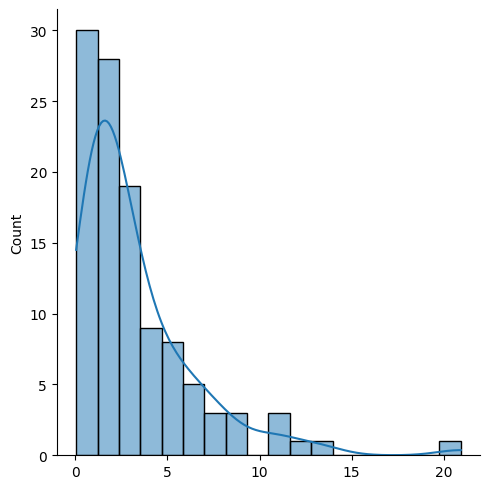

In [ ]:
df["tiempo_servicio_sec"] = (df["Tiempo de Salida"] - df["Tiempo de Inicio"]).dt.total_seconds()

df.loc[df["tiempo_servicio_sec"] <= 0, "tiempo_servicio_sec"] = np.nan
df = df.dropna(subset=["tiempo_servicio_sec"])
df["tiempo_servicio_min"] = df["tiempo_servicio_sec"] / 60

tiempo_servicio = df["tiempo_servicio_min"].to_numpy()
print(len(tiempo_servicio))
sns.displot(x=tiempo_servicio, kde=True)

In [ ]:
arr = np.array(tiempo_servicio)
print("tiempo_s: size", len(arr), "min", arr.min(), "n_neg", np.sum(arr <= 0))

tiempo_s: size 111 min 0.05 n_neg 0


TIEMPO ENTRE LLEGADAS

110


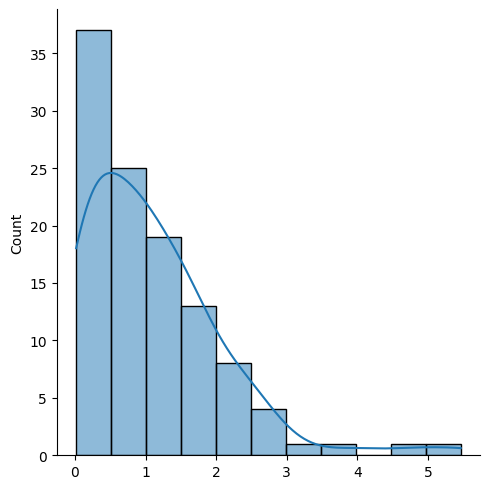

In [ ]:
df = df.sort_values("Tiempo de Llegada")
lleg_seg = df["Tiempo de Llegada"].dt.hour * 3600 + df["Tiempo de Llegada"].dt.minute * 60 + df["Tiempo de Llegada"].dt.second
interarrival_sec = np.diff(lleg_seg)
tiempo_entre_llegadas = interarrival_sec / 60
print(len(tiempo_entre_llegadas))
sns.displot(x=tiempo_entre_llegadas, kde=True)

AJUSTE DE DISTRIBUCION DE DATOS

AJUSTE DE TIEMPO DE SERVICIO

{'name': 'lognorm', 'score': 0.0016243589149228695, 'loc': -0.15448812097694997, 'scale': 2.3844033019026347, 'arg': (np.float64(0.8522277002482862),), 'params': (np.float64(0.8522277002482862), -0.15448812097694997, np.float64(2.3844033019026347)), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf2e594f230>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': np.float64(0.43244704291784297), 'CII_max_alpha': np.float64(9.532065787971119)}


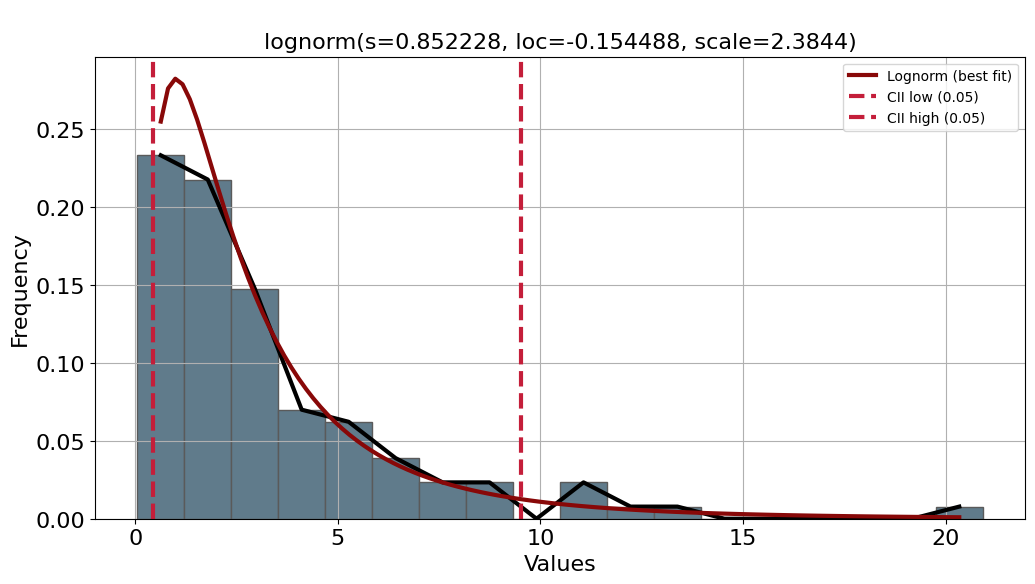

(np.float64(0.8522277002482862), -0.15448812097694997, np.float64(2.3844033019026347))


In [ ]:
d = distfit(todf=False)
data = np.array(tiempo_servicio)
d.fit_transform(data, verbose=False)
print(d.model)
d.plot()
plt.gcf().set_size_inches(12, 6)
plt.show()
print(d.model['params'])

AJUSTE DE TIEMPO ENTRE LLEGADAS

{'name': 'expon', 'score': 0.011345495603177016, 'loc': 0.016666666666666666, 'scale': 1.0804545454545453, 'arg': (), 'params': (0.016666666666666666, 1.0804545454545453), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf2e5870590>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': np.float64(0.07208673973903376), 'CII_max_alpha': np.float64(3.2534192185929545)}


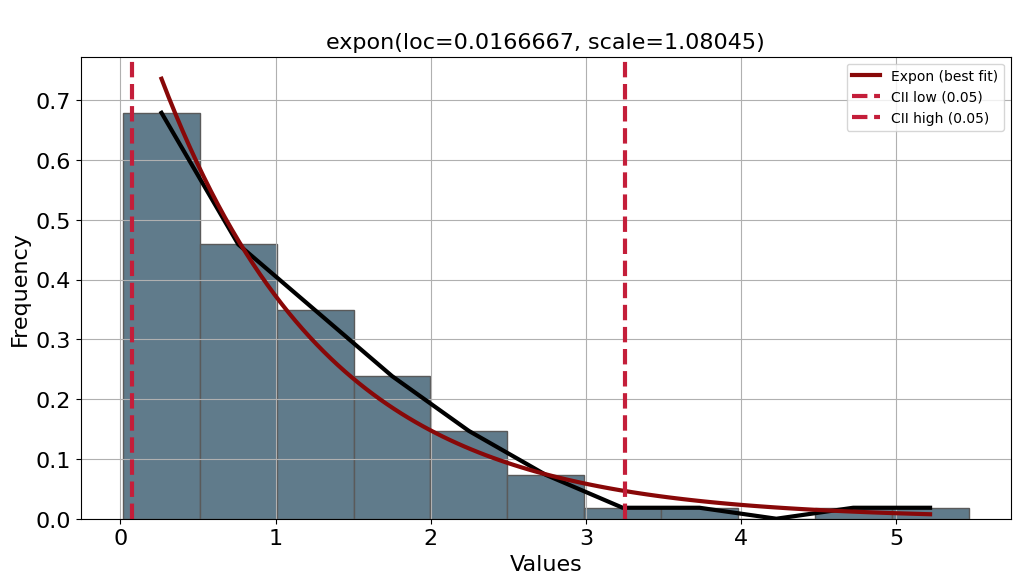

(0.016666666666666666, 1.0804545454545453)


In [ ]:
d = distfit(todf=False)
data = np.array(tiempo_entre_llegadas)
d.fit_transform(data, verbose=False)
print(d.model)
d.plot()
plt.gcf().set_size_inches(12, 6)
plt.show()
print(d.model['params'])

SIMULACION EN DATOS PRODUCIDOS

TIEMPO DE SERVICIO

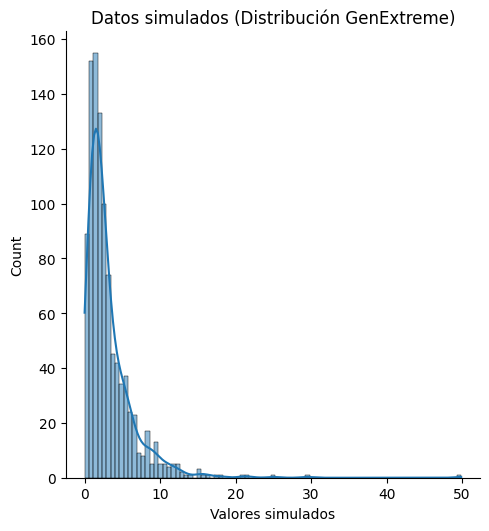

In [ ]:
N = 1000
tiempo_s = lognorm.rvs(s=0.852228, loc=-0.154488, scale=2.384403, size=N, random_state=123)
sns.displot(x=tiempo_s, kde=True)
plt.title("Datos simulados (Distribución GenExtreme)")
plt.xlabel("Valores simulados")
plt.show()

TIEMPO ENTRE LLEGADAS

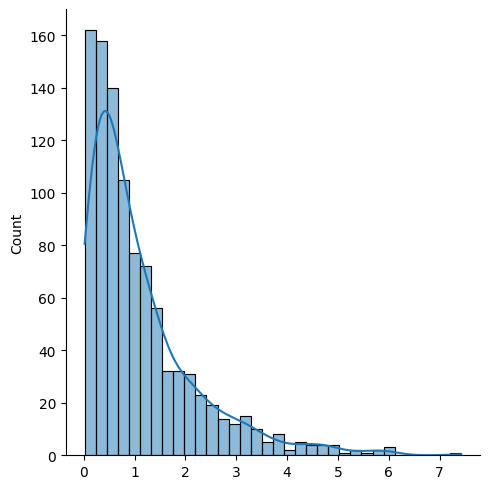

In [ ]:

tiempo_e_l = expon.rvs(loc=0.016666, scale=1.0845, size=N, random_state=123)
sns.displot(x = tiempo_e_l, kde=True)


TIEMPO DE LLEGADA

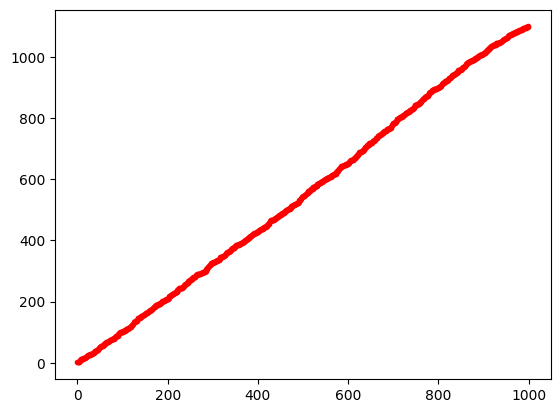

In [ ]:
tiempo_de_llegada = np.cumsum(tiempo_e_l)
plt.plot(range(len(tiempo_de_llegada)),tiempo_de_llegada, marker=".", color="red")
plt.show()

SIMULACION

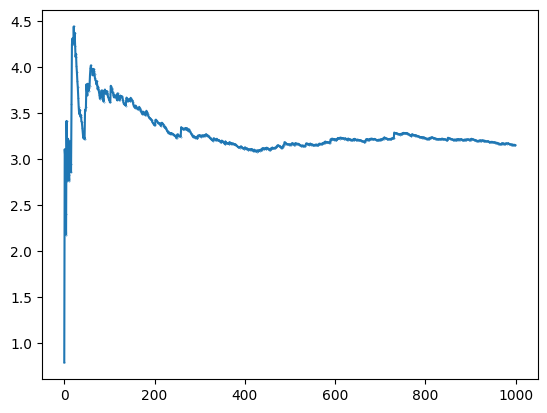

In [ ]:
N = len(tiempo_de_llegada)

inicio_servicio = []
fin_servicio = []
tiempo_espera = []
tiempo_en_sistema = []
tiempo_promedio_en_servicio = []
cajero_libre_en = np.zeros(3)
tiempo_en_servicio = []
cajero_que_atendio = []

for i in range(N):
    cajero = np.argmin(cajero_libre_en)
    cajero_que_atendio.append(cajero)
    inicio = max(tiempo_de_llegada[i], cajero_libre_en[cajero])
    fin = inicio + tiempo_s[i]

    inicio_servicio.append(inicio)
    fin_servicio.append(fin)
    tiempo_espera.append(inicio - tiempo_de_llegada[i])
    tiempo_en_sistema.append(fin - tiempo_de_llegada[i])

    cajero_libre_en[cajero] = fin
    tiempo_en_servicio.append(fin - inicio)

    tiempo_promedio_en_servicio.append(np.mean(tiempo_en_servicio))

plt.plot(tiempo_promedio_en_servicio, marker=".", markersize=0.5)
plt.show()


In [ ]:
df = pd.DataFrame(list(zip(
    tiempo_e_l,
    tiempo_de_llegada,
    inicio_servicio,
    tiempo_en_servicio,
    fin_servicio,
    tiempo_promedio_en_servicio,
    cajero_que_atendio)),

    columns =[
              'Tiempo entre llegadas',
              'Tiempo de llegada',
              'Inicio de servicio',
              'Tiempo en servicio',
              'Fin de serivicio',
              'Tiempo promedio de servicio',
              'Cajero que atendio'])
df

,Tiempo entre llegadas,Tiempo de llegada,Inicio de servicio,Tiempo en servicio,Fin de serivicio,Tiempo promedio de servicio,Cajero que atendio
0,1.309685,1.309685,1.309685,0.790809,2.100494,0.790809,0
1,0.382216,1.691901,1.691901,5.423982,7.115883,3.107395,1
2,0.295691,1.987591,1.987591,2.880207,4.867799,3.031666,2
3,0.885821,2.873412,2.873412,0.506012,3.379425,2.400253,0
4,1.395142,4.268555,4.268555,1.301740,5.570295,2.180550,0
...,...,...,...,...,...,...,...
995,0.349678,1097.142916,1102.939002,3.941106,1106.880108,3.154413,2
996,1.290021,1098.432937,1104.375318,5.779897,1110.155215,3.157046,0
997,0.479099,1098.912036,1106.880108,0.944066,1107.824174,3.154829,2
998,0.021196,1098.933232,1107.508500,3.405370,1110.913870,3.155080,1


REPLICAS


In [ ]:
num_replicas = 100
N=1000

In [ ]:
def simulacion_replica():
  tiempo_e_l = expon.rvs(loc=0.016666, scale=1.0845, size=N)
  tiempo_s = lognorm.rvs(s=0.852228, loc=-0.154488, scale=2.384403, size=N)
  tiempo_de_llegada = np.cumsum(tiempo_e_l)

  inicio_servicio = []
  fin_servicio = []
  tiempo_espera = []
  tiempo_en_sistema = []
  tiempo_promedio_en_servicio = []
  cajero_libre_en = np.zeros(4)
  tiempo_en_servicio = []

  for i in range(N):

    cajero = np.argmin(cajero_libre_en)

    inicio = max(tiempo_de_llegada[i], cajero_libre_en[cajero])
    fin = inicio + tiempo_s[i]

    inicio_servicio.append(inicio)
    fin_servicio.append(fin)
    tiempo_espera.append(inicio - tiempo_de_llegada[i])
    tiempo_en_sistema.append(fin - tiempo_de_llegada[i])

    cajero_libre_en[cajero] = fin
    tiempo_en_servicio.append(fin - inicio)

    tiempo_promedio_en_servicio.append(np.mean(tiempo_en_servicio))

  return tiempo_promedio_en_servicio

0  10  20  30  40  50  60  70  80  90  

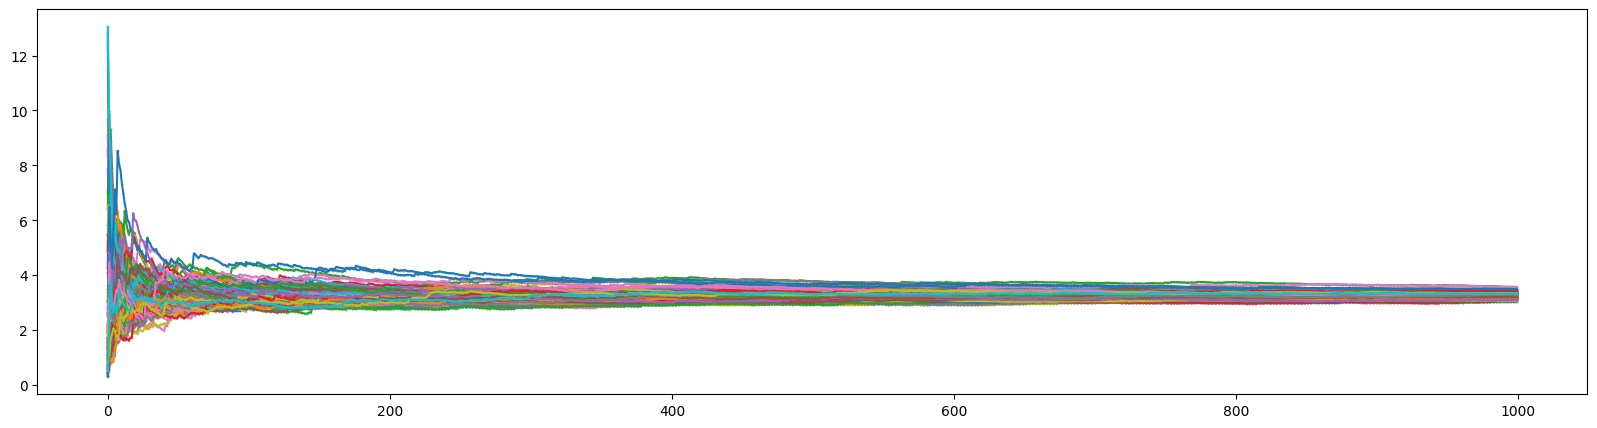

In [ ]:
replica_promedio_espera_acumulado = []

plt.figure(figsize=(20,5))

for replica in range(0,num_replicas):
  replica_promedio_espera_acumulado.append(simulacion_replica())
  if replica%10 == 0:
    print(replica," ",end="")
  plt.plot(range(N),replica_promedio_espera_acumulado[replica], marker=".", markersize=0.5)
plt.show()

Media: 3.2858013775297876 minutos/clientes
Desviación estándar: 0.11536391479570882 minutos/clientes


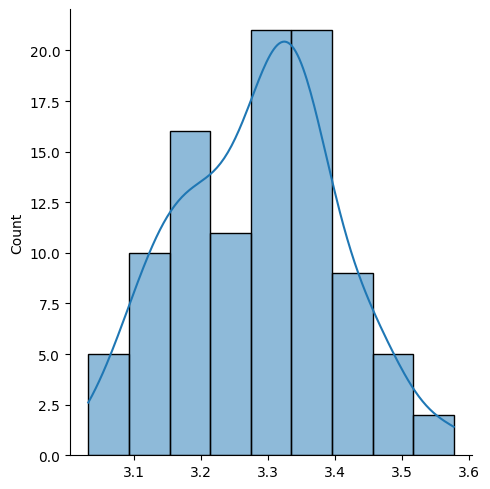

In [ ]:
promedio_final_replica = []
for replica in range(0,num_replicas):
  promedio_final_replica.append(replica_promedio_espera_acumulado[replica][-1])

sns.displot(None, x = promedio_final_replica, kde=True)
print("Media:", np.mean(promedio_final_replica), "minutos/clientes")
print("Desviación estándar:", np.std(promedio_final_replica), "minutos/clientes")

COMPARACIONES

In [58]:
def simulacion_replica(k):
    tiempo_e_l = expon.rvs(loc=0.016666, scale=1.0845, size=N)
    tiempo_s = lognorm.rvs(s=0.852228, loc=-0.154488, scale=2.384403, size=N)
    tiempo_de_llegada = np.cumsum(tiempo_e_l)

    inicio_servicio = []
    fin_servicio = []
    tiempo_espera = []
    tiempo_en_sistema = []
    tiempo_en_servicio = []
    tiempo_promedio_en_servicio = []

    cajero_libre_en = np.zeros(k)

    for i in range(N):
        cajero = np.argmin(cajero_libre_en)
        inicio = max(tiempo_de_llegada[i], cajero_libre_en[cajero])
        fin = inicio + tiempo_s[i]

        inicio_servicio.append(inicio)
        fin_servicio.append(fin)
        tiempo_espera.append(inicio - tiempo_de_llegada[i])
        tiempo_en_sistema.append(fin - tiempo_de_llegada[i])
        tiempo_en_servicio.append(fin - inicio)

        cajero_libre_en[cajero] = fin
        tiempo_promedio_en_servicio.append(np.mean(tiempo_en_servicio))

    return tiempo_promedio_en_servicio


In [ ]:
df = []

for k in escenarios:
    for r in resultados[k]:
        df.append({
            "Servidores": k,
            "Espera": r["espera_promedio"],
            "Sistema": r["sistema_promedio"],
            "Servicio": r["servicio_promedio"],
            "Llegada": r["llegada_promedio"],
            "Prob_Espera": r["prob_espera"]
        })

df = pd.DataFrame(df)
df


,Servidores,Espera,Sistema,Servicio,Llegada,Prob_Espera
0,3,2.853097,5.225997,2.372899,1.097770,0.526
1,3,1.950253,4.173931,2.223677,1.111045,0.437
2,3,0.783728,2.673487,1.889759,1.140560,0.314
3,3,1.505073,3.523103,2.018030,1.054203,0.436
4,3,2.590344,4.894660,2.304316,1.102606,0.468
...,...,...,...,...,...,...
295,5,0.063867,2.360552,2.296685,1.125026,0.062
296,5,0.089809,2.476938,2.387130,1.013417,0.094
297,5,0.060903,2.618579,2.557675,1.179221,0.057
298,5,0.056791,2.386313,2.329522,1.065638,0.065


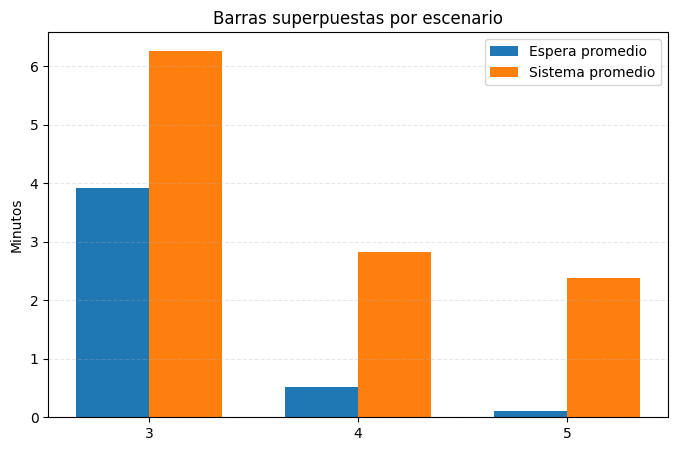

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))

mean_espera = df.groupby("Servidores")["Espera"].mean()
mean_sistema = df.groupby("Servidores")["Sistema"].mean()

x = np.arange(len(escenarios))
w = 0.35

plt.bar(x - w/2, mean_espera, width=w, label="Espera promedio")
plt.bar(x + w/2, mean_sistema, width=w, label="Sistema promedio")

plt.xticks(x, escenarios)
plt.ylabel("Minutos")
plt.title("Barras superpuestas por escenario")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


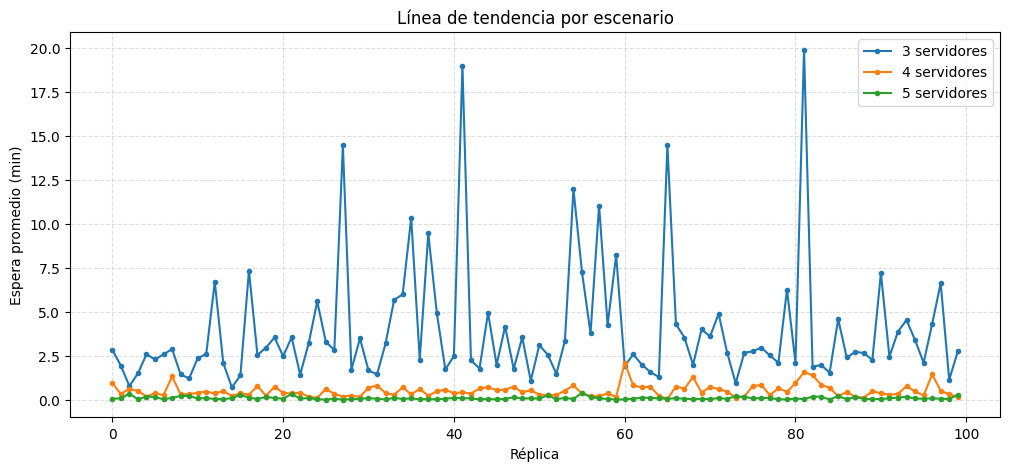

In [ ]:
plt.figure(figsize=(12,5))

for k in escenarios:
    plt.plot(df[df["Servidores"] == k]["Espera"].values,
             marker=".",
             label=f"{k} servidores")

plt.xlabel("Réplica")
plt.ylabel("Espera promedio (min)")
plt.title("Línea de tendencia por escenario")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


/tmp/ipython-input-281851537.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Servidores", y="Espera", data=df, palette="Set2")


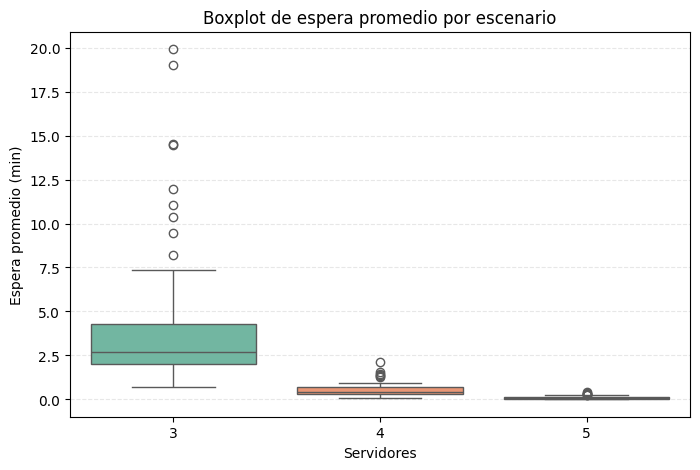

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))

sns.boxplot(x="Servidores", y="Espera", data=df, palette="Set2")

plt.ylabel("Espera promedio (min)")
plt.title("Boxplot de espera promedio por escenario")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


TABLAS COMPARATIVAS DE RESULTADOS

In [ ]:
tabla_global = []

for k in escenarios:
    df_temp = pd.DataFrame(resultados[k])
    tabla_global.append({
        "Servidores": k,
        "Espera promedio (min)": df_temp["espera_promedio"].mean(),
        "Sistema promedio (min)": df_temp["sistema_promedio"].mean(),
        "Servicio promedio (min)": df_temp["servicio_promedio"].mean(),
        "Llegada promedio (min)": df_temp["llegada_promedio"].mean(),
        "Probabilidad de esperar (%)": df_temp["prob_espera"].mean() * 100
    })

df_resultados_globales = pd.DataFrame(tabla_global)
df_resultados_globales


,Servidores,Espera promedio (min),Sistema promedio (min),Servicio promedio (min),Llegada promedio (min),Probabilidad de esperar (%)
0,3,3.913057,6.268971,2.355914,1.099906,52.214
1,4,0.517541,2.818211,2.300670,1.094059,21.182
2,5,0.099847,2.377214,2.277367,1.104723,7.390


In [ ]:
tabla_metricas = []

for k in escenarios:
    df_temp = pd.DataFrame(resultados[k])
    tabla_metricas.append({
        "Servidores": k,
        "Espera promedio (min)": df_temp["espera_promedio"].mean(),
        "Sistema promedio (min)": df_temp["sistema_promedio"].mean(),
        "Probabilidad de esperar (%)": df_temp["prob_espera"].mean() * 100
    })

df_metricas_resumidas = pd.DataFrame(tabla_metricas)
df_metricas_resumidas


,Servidores,Espera promedio (min),Sistema promedio (min),Probabilidad de esperar (%)
0,3,3.913057,6.268971,52.214
1,4,0.517541,2.818211,21.182
2,5,0.099847,2.377214,7.390
